# SAC
This notebook trains an agent using current state-of-the-art algorithm SAC which is similar to DDPG and TD3. SAC is an off-policy actor-critic RL method, which maximizes an objective with **entropy regularization**: $J = J_θ + α H(π_θ)$, where $J_θ$ is the expected return with respect to the parameters $\theta$ of our policy, which we typically maximize, $H$ is the entropy and $\alpha$ is a hyperparameter to balance it. 

The agent will solve the LunarLander environment from Gymnasium to safely land a vehicle on the surface on the moon.

<img src="resources/lunar_lander.gif" alt="Gymnasium" width="20%"/>

<!--  -->
_Agent using random actions to land the lunarlander_

In [14]:
# Imports
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## Critic
Define Critic network which will estimate the expected cumulative reward.

In [15]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        Initialize the Critic network.
        
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3.bias.data.uniform_(-3e-3, 3e-3) 



    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, action], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out


## Actor 
Definition of the Actor network. In contrast to DDPG, SAC uses a stochastic policy. This means that the actor outputs a probability distribution over the actions. The distribution is parameterized by a mean $\mu$ and a standard deviation $\sigma$. Typically, the stochastic policy is modeled with a squashed diagonal Gaussian distribution. The squashing function is used to ensure that the actions are within the bounds of the environment's action space.

### Reparameterization Trick
The reason for using a stochastic policy is to allow exploration. However, the stochasticity (sampling directly from $\mathcal{N}(\mu(s), \sigma(s))$) makes it difficult to compute the gradients of the loss function. This is where the reparameterization trick comes in. The trick is to sample the action from a deterministic distribution ($\mu(s)$ and $\sigma(s)$) and then add noise ($\mathcal{N}(0, \mathcal{I})$). This way, the gradients can be computed with respect to the deterministic distribution, while the actions are still sampled from the stochastic distribution.

$$
a \sim \mathcal{N}(\mu(s), \sigma(s)) => \mu(s) + \sigma(s) \cdot \mathcal{N}(0, \mathcal{I})
$$


In [61]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        Initialize the Actor network.
        
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Actor, self).__init__()
        # We are registering scale and bias as buffers so they can be saved and loaded as part of the model.
        # Buffers won't be passed to the optimizer for training!
        #self.register_buffer(
        #    "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        #)
        #self.register_buffer(
        #    "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        #)
        self.action_low = action_low
        self.action_high = action_high
        
        self.fc1 = nn.Linear(obs_dim, 256)
        #self.fc_mu = nn.Linear(256, action_dim)
        #self.fc_std = nn.Linear(256, action_dim)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.fc32 = nn.Linear(256, action_dim)

        
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc32.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3.bias.data.uniform_(-3e-3, 3e-3)
        self.fc32.bias.data.uniform_(-3e-3, 3e-3)

    def forward(self, obs: torch.Tensor) -> "tuple[torch.Tensor, torch.Tensor]":
        """
        Forward pass of the actor network.
        
        return: mean_action, log_prob_action
        """
        #x = F.relu(self.fc1(obs))
        ##mu = self.fc_mu(x)
        ##std = F.softplus(self.fc_std(x)) 
        #x = F.relu(self.fc2(x))
        #out = self.fc3(x)
        #mu, std = torch.chunk(out, 2, dim=-1)
        #std = F.softplus(std)
        #dist = torch.distributions.Normal(mu, std)
        #action = dist.rsample()
        #log_prob = dist.log_prob(action)
        ## Enforcing action bounds
        ##adjusted_action = torch.tanh(action) * self.action_scale + self.action_bias
        ##adjusted_log_prob = log_prob - torch.log(self.action_scale * (1-torch.tanh(action).pow(2)) + 1e-6)
        ##adjusted_action = torch.tanh(action)
        ##adjusted_log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-6)
        #action_scale = torch.tensor((self.action_high - self.action_low) / 2.0, dtype=torch.float32)
        #action_bias = torch.tensor((self.action_high + self.action_low) / 2.0, dtype=torch.float32)
        #adjusted_action = torch.tanh(action) * action_scale + action_bias
        #adjusted_log_prob = log_prob - torch.log(action_scale * (1-torch.tanh(action).pow(2)) + 1e-6)
        #return adjusted_action, adjusted_log_prob
        
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        m = self.fc3(x)
        log_stdev = self.fc32(x)
        log_stdev = torch.clamp(log_stdev, -30, 30)

        stdev = log_stdev.exp()
        u = m + stdev * torch.randn_like(m)
        a = torch.tanh(u)
        llhood = (torch.distributions.Normal(m, stdev).log_prob(u) - torch.log(
            torch.clamp(1- a.pow(2), 1e-6, 1.0)
        )).sum(dim=-1, keepdim=True)

        return a, llhood


# Value

In [17]:
class Value(nn.Module):
    def __init__(self, obs_dim: int):
        """
        Initialize the Value network.
        
        :param obs_dim: dimention of the observations
        """
        super(Value, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3.bias.data.uniform_(-3e-3, 3e-3) 

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.fc1(obs))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out

## Replay Buffer

Implementation of the replay buffer

In [51]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)   
        self.position = (self.position + 1) % self.max_size         

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

## Updates
Update functions for critics and actor. 

``update_critics`` gets the sampled data from the replay buffer, calculates the loss of both critics, respectively, and performs an update step.

The target for our critics is given by:

$y = r + \gamma(1-tm)(\min_{j=1,2}Q_{\text{targ, j}}(s', \tilde{a}') - \alpha \log \pi_\theta(\tilde{a}'|s'))$
with action $\tilde{a}' \sim \pi_\theta(\cdot | s')$ sampled from our actor

## Polyak Update of the target networks
The polyak update updates the target networks very slowly at every step.

In [19]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    """
    Perform a Polyak average update on ``target_params`` using ``params``:

    :param params: parameters of the original network (model.parameters())
    :param target_params: parameters of the target network (model_target.parameters())
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 1 -> Hard update, 0 -> No update
    """
    with torch.no_grad():
        for param, target_param in zip(params, target_params):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

## SAC Agent 
The SAC agent puts above functions together

In [ ]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards",
                                    "value_loss", "q1_loss", "q2_loss", "actor_loss"])

class SACAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            tau=0.005,
            maxlen=100_000,
            target_entropy=-1.0,
        ):
        """
        Initialize the SAC agent.

        :param env: The environment.
        :param exploration_noise.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param tau: Polyak update coefficient.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.target_entropy=target_entropy

        # Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # Initialize two critic and one actor network
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.q1 = Critic(obs_dim, action_dim) # Q1 (critic)
        self.q2 = Critic(obs_dim, action_dim) # Q2 (critic)
        self.actor = Actor(obs_dim, action_dim, env.action_space.low, env.action_space.high) # policy
        self.value = Value(obs_dim) # Value function
        self.target_value = Value(obs_dim) # Target Value function
        
        # Create ADAM optimizer for the Critic and Actor networks
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.target_value_optimizer = optim.Adam(self.target_value.parameters(), lr=lr)

        polyak_update(self.value.parameters(), self.target_value.parameters(), 1.0)

        self.reward_scale = 100.0
        self.alpha = 1.0
        self.grad_steps = 1


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the SAC agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
            value_loss=np.zeros(num_episodes),
            q1_loss=np.zeros(num_episodes),
            q2_loss=np.zeros(num_episodes),
            actor_loss=np.zeros(num_episodes),
        )
        current_timestep = 0

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 10 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}')
                print(f'\tValue Loss: {value_loss.item()}, Q1 Loss: {loss_q1.item()}, Q2 Loss: {loss_q2.item()}, Actor Loss: {actor_loss.item()}')
            

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                # Choose action and execute
                with torch.no_grad():
                    action, _ = self.actor(torch.as_tensor(obs).float())
                    #action = action.cpu().numpy().clip(self.env.action_space.low, self.env.action_space.high)
                    action = (0.5*(action+1.0)*(self.env.action_space.high[0]-self.env.action_space.low[0]) + self.env.action_space.low[0])
                next_obs, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated, dtype=torch.int),
                )
                
                if len(self.buffer) >= self.batch_size:

                    for _ in range(0, self.grad_steps):

                        # Sample a mini batch from the replay buffer
                        obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                        #value = value.view(-1)

                        # Update the Critic network
                        q1 = self.q1(obs_batch, act_batch)
                        q2 = self.q2(obs_batch, act_batch)
                        target_value = self.target_value(next_obs_batch)
                        q_target = self.reward_scale * rew_batch + self.gamma * target_value

                        loss_q1 = F.mse_loss(q1, q_target.detach())
                        self.q1_optimizer.zero_grad()
                        loss_q1.backward()
                        self.q1_optimizer.step()

                        loss_q2 = F.mse_loss(q2, q_target.detach())
                        self.q2_optimizer.zero_grad()
                        loss_q2.backward()
                        self.q2_optimizer.step()

                        # Update the Value network
                        #with torch.no_grad():
                        value = self.value(obs_batch)
                        next_action, action_log_prob = self.actor(obs_batch)
                        q1, q2 = self.q1(obs_batch, next_action), self.q2(obs_batch, next_action)
                        critic = torch.min(q1, q2)
                        value_target = critic - self.alpha * action_log_prob

                        value_loss = F.mse_loss(value, value_target.detach())
                        self.value_optimizer.zero_grad()
                        value_loss.backward()
                        self.value_optimizer.step()


                        # Update the Actor network
                        actor_loss = (action_log_prob - critic).mean()
                        self.actor_optimizer.zero_grad()
                        actor_loss.backward()
                        self.actor_optimizer.step()


                        # Update the target Value network
                        polyak_update(self.value.parameters(), self.target_value.parameters(), self.tau)
                
                
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break

                obs = next_obs


            stats.value_loss[i_episode] = value_loss.item()
            stats.q1_loss[i_episode] = loss_q1.item()
            stats.q2_loss[i_episode] = loss_q2.item()
            stats.actor_loss[i_episode] = actor_loss.item()
            
        return stats

## Training
We train now on the Lunar Lander environment from (Gymnasium)[https://gymnasium.farama.org/environments/box2d/lunar_lander/]. Note that the result could be improved if we would train for more (very time-consuming) episodes. 

In [21]:
# SUCCESS NEAR 300
LR = 0.001
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
NUM_EPISODES = 600
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -1.0

In [22]:
# NEW
LR = 0.001
BATCH_SIZE = 256
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
NUM_EPISODES = 500
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -1.0

In [23]:
# NEW 2
LR = 0.0003
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 50_000
TAU = 0.005
NUM_EPISODES = 1000
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -1.0

In [24]:
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)
#torch.backends.cudnn.deterministic = True

In [69]:
# Choose your environment
env = gym.make("LunarLander",
    continuous = True,
    render_mode="rgb_array")
# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

with torch.device("cuda"):
    # Train SAC
    agent = SACAgent(
        env, 
        gamma=DISCOUNT_FACTOR,
        lr=LR,
        batch_size=BATCH_SIZE,
        tau=TAU,
        maxlen=REPLAY_BUFFER_SIZE,
        target_entropy=TARGET_ENTROPY,
    )
    stats = agent.train(NUM_EPISODES)

c:\Users\matte\anaconda3\envs\rl-playground\lib\site-packages\gymnasium\envs\registration.py:531: UserWarning: WARN: Using the latest versioned environment `LunarLander-v2` instead of the unversioned environment `LunarLander`.
  logger.warn(


Training on LunarLander-v2
Observation space: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)



c:\Users\matte\anaconda3\envs\rl-playground\lib\site-packages\torch\utils\_device.py:78: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


Episode 10 of 1000  Time Step: 1074
	Value Loss: 1.4566936492919922, Q1 Loss: 33115.9921875, Q2 Loss: 33113.6875, Actor Loss: -1.252044677734375
Episode 20 of 1000  Time Step: 2095
	Value Loss: 0.8257203102111816, Q1 Loss: 54848.0625, Q2 Loss: 54842.78125, Actor Loss: -1.1213632822036743
Episode 30 of 1000  Time Step: 3449
	Value Loss: 0.09198827296495438, Q1 Loss: 50298.3828125, Q2 Loss: 50291.6796875, Actor Loss: -0.815386176109314
Episode 40 of 1000  Time Step: 4648
	Value Loss: 0.31514817476272583, Q1 Loss: 39925.55078125, Q2 Loss: 39908.53125, Actor Loss: -0.2962080240249634
Episode 50 of 1000  Time Step: 5695
	Value Loss: 1.6642767190933228, Q1 Loss: 53105.015625, Q2 Loss: 53064.6640625, Actor Loss: 0.7719287872314453
Episode 60 of 1000  Time Step: 6751
	Value Loss: 5.856757164001465, Q1 Loss: 3184532.0, Q2 Loss: 3184315.75, Actor Loss: 2.2173969745635986
Episode 70 of 1000  Time Step: 7773
	Value Loss: 15.536150932312012, Q1 Loss: 53121.4765625, Q2 Loss: 53065.8515625, Actor Los

KeyboardInterrupt: 

### Save and Load the trained actor

In [ ]:
# save the trained actor
data = agent.actor.to("cpu")
torch.save(data, "sac_actor2.pt")

# loading the trained actor
loaded_actor = torch.load("sac_actor2.pt")
loaded_actor.eval()
print(loaded_actor)

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


# Results

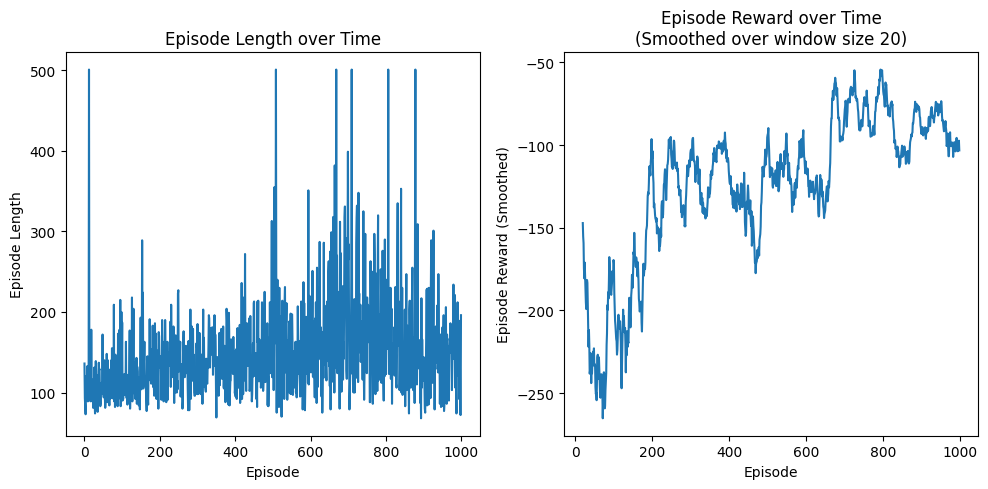

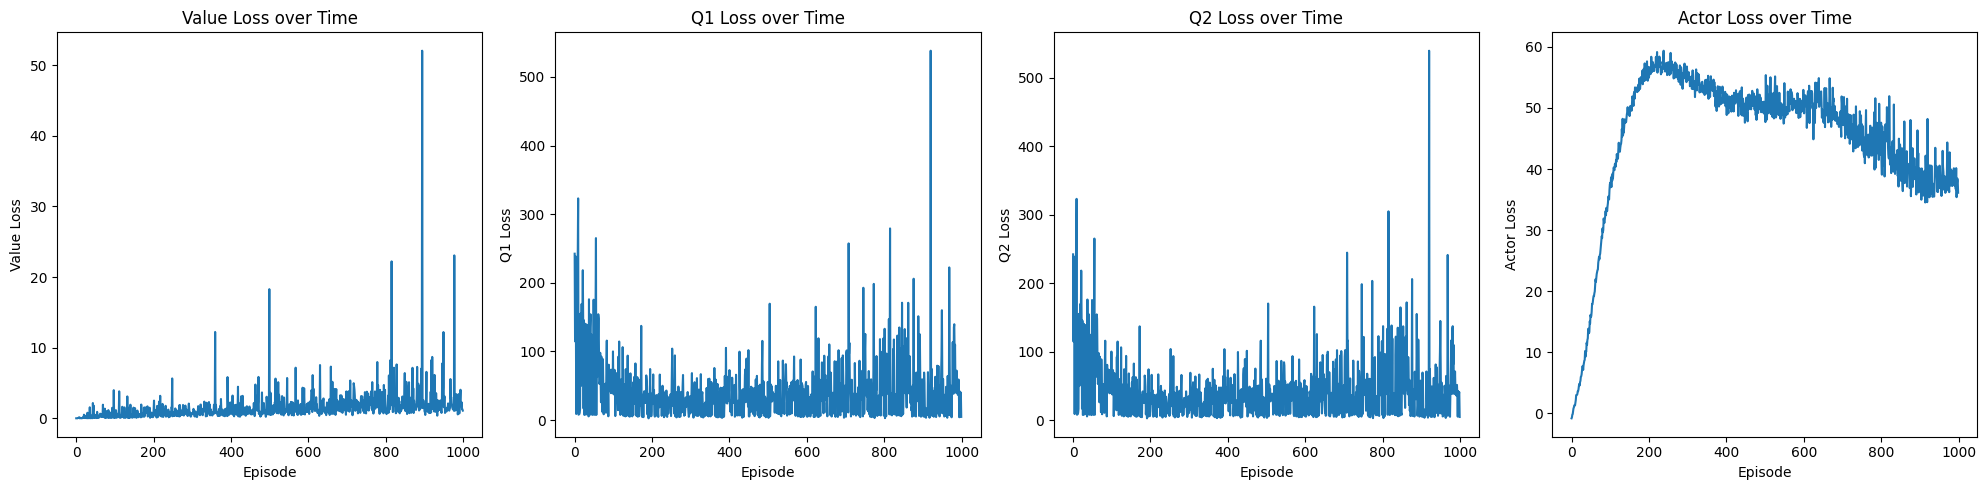

In [ ]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

# Plot the losses (value, q1, q2, actor) over time
fig, axes = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)

# Plot the value loss over time
ax = axes[0]
ax.plot(stats.value_loss)
ax.set_xlabel("Episode")
ax.set_ylabel("Value Loss")
ax.set_title("Value Loss over Time")

# Plot the q1 loss over time
ax = axes[1]
ax.plot(stats.q1_loss)
ax.set_xlabel("Episode")
ax.set_ylabel("Q1 Loss")
ax.set_title("Q1 Loss over Time")

# Plot the q2 loss over time
ax = axes[2]
ax.plot(stats.q2_loss)
ax.set_xlabel("Episode")
ax.set_ylabel("Q2 Loss")
ax.set_title("Q2 Loss over Time")

# Plot the actor loss over time
ax = axes[3]
ax.plot(stats.actor_loss)
ax.set_xlabel("Episode")
ax.set_ylabel("Actor Loss")
ax.set_title("Actor Loss over Time")
plt.show()

Lastly, let us see what the learned policy does in action.

Reward -200


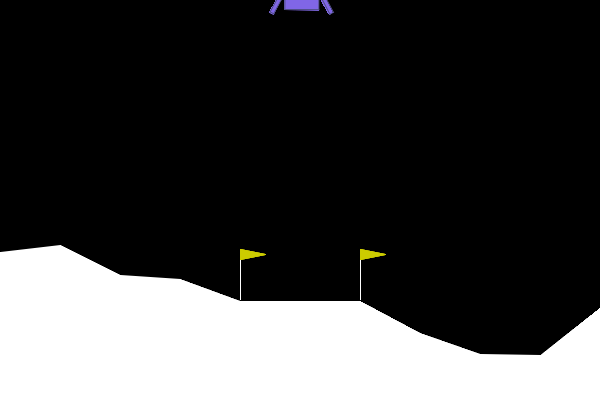

In [ ]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]
    rew = 0

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32))[0].cpu().numpy()
            
        obs, rew, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        rew += rew
        
        if terminated or truncated:
            break

    return imgs, rew

imgs, rew = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
print("Reward", rew)
IImage(filename="trained.gif")